# Data Prep for Model 1
In this notebook we will clean the flights_10000 dataset

We will incoporate these additional features: weather, categorical variables to numeric variables

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from src.modules.data_preprocessing import time_of_day, feature_categorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
flights = pd.read_csv('data/flights_10000.csv')

In [3]:
flights.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,orig_weather_categ,dest_weather_categ
0,2018-07-10,WN,WN,WN,2212,WN,N958WN,2212,14683,SAT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cloudy,cloudy
1,2019-10-10,UA,UA,UA,206,UA,N68811,206,13930,ORD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rain,rain


In [4]:
X = flights.drop(['arr_delay'], axis = 1)
y = flights['arr_delay']

In [5]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
flights_M1 = X_train

## Replace null with 0

In [7]:
pd.isnull(flights_M1).sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                 24
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                119
dep_delay               124
taxi_out                127
wheels_off              127
wheels_on               132
taxi_in                 132
crs_arr_time              0
arr_time                128
cancelled                 0
cancellation_code      7875
diverted                  0
dup                       0
crs_elapsed_time          0
actual_elapsed_time     147
air_time                151
flights                   0
distance                  0
carrier_delay          6488
weather_delay          6488
nas_delay              6488
security_delay      

In [8]:
flights_M1.fillna(0, inplace = True)

## Add Features
### Add time of day feature

In [9]:
flights_M1['dep_time_of_day'] = flights_M1.apply(lambda df: time_of_day(df, method='dep'), axis=1)
flights_M1['arr_time_of_day'] = flights_M1.apply(lambda df: time_of_day(df, method='arr'), axis=1)

In [10]:
feature_categorizer(flights_M1[['dep_time_of_day','arr_time_of_day']], flights_M1)

In [11]:
flights_M1.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,orig_weather_categ,dest_weather_categ,dep_time_of_day,arr_time_of_day
9254,2018-12-16,UA,UA,UA,1716,UA,N76503,1716,13198,MCI,...,0.0,0.0,0.0,0.0,0.0,0.0,sunny,sunny,0,0
1561,2019-07-09,AA,AA_CODESHARE,AA,5591,OH,N556NN,5591,10599,BHM,...,0.0,0.0,0.0,0.0,0.0,0.0,sunny,rain,0,0


In [12]:
flights_M1.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
tail_num                object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
cancelled              float64
cancellation_code       object
diverted               float64
dup                     object
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
flights                float64
distance               float64
carrier_

### Create mean delay by airport feature to use in place of origin airport

In [13]:
mean_delay_orig_airport = flights[['origin', 'arr_delay']].groupby(by = 'origin').mean().reset_index()
mean_delay_orig_airport

,origin,arr_delay
0,ABE,0.461538
1,ABI,18.000000
2,ABQ,3.342857
3,ABY,-15.000000
4,ACK,-19.000000
...,...,...
307,WRG,2.666667
308,XNA,2.727273
309,XWA,-14.000000
310,YAK,81.000000


In [14]:
#rename aggregate column
mean_delay_orig_airport.rename({'arr_delay':'mean_arr_delay_orig_airport'},axis = 1, inplace= True)

In [15]:
#merge this mean value to flights_M1 with origin as key
flights_M1 = pd.merge(flights_M1, mean_delay_orig_airport, how = 'left', on = ['origin'])

In [16]:
#mean delay for dest airport
mean_delay_dest_airport = flights[['dest', 'arr_delay']].groupby(by = 'dest').mean().reset_index()
mean_delay_dest_airport.rename({'arr_delay':'mean_arr_delay_dest_airport'},axis = 1, inplace= True)

In [17]:
mean_delay_dest_airport.head(1)

,dest,mean_arr_delay_dest_airport
0,ABE,20.5


In [18]:
#merge this mean value to flights_M1 with dest as key
flights_M1 = pd.merge(flights_M1, mean_delay_dest_airport, how = 'left', on = ['dest'])

### Create mean delay by carrier feature

<AxesSubplot:xlabel='mkt_unique_carrier', ylabel='arr_delay'>

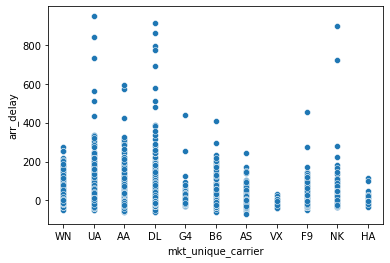

In [19]:
import seaborn as sns
sns.scatterplot(data=flights, x="mkt_unique_carrier", y="arr_delay")

In [20]:
#mean delay for carrier
mean_delay_carrier = flights[['mkt_unique_carrier', 'arr_delay']].groupby(by = 'mkt_unique_carrier').mean().reset_index()

In [21]:
mean_delay_carrier

,mkt_unique_carrier,arr_delay
0,AA,5.238848
1,AS,0.251327
2,B6,12.448753
3,DL,3.892650
4,F9,16.618750
5,G4,6.624000
6,HA,1.037736
7,NK,10.057143
8,UA,8.433741
9,VX,-8.600000


In [22]:
mean_delay_carrier.rename({'arr_delay':'mean_arr_delay_carrier'},axis = 1, inplace= True)

In [23]:
#merge this mean value to flights_M1 with mkt unique carrier as key
flights_M1 = pd.merge(flights_M1, mean_delay_carrier, how = 'left', on = ['mkt_unique_carrier'])

In [24]:
flights_M1.head(1)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,total_add_gtime,longest_add_gtime,no_name,orig_weather_categ,dest_weather_categ,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier
0,2018-12-16,UA,UA,UA,1716,UA,N76503,1716,13198,MCI,...,0.0,0.0,0.0,sunny,sunny,0,0,-1.652778,8.167139,8.433741


In [25]:
#now we can drop the 'mkt_unique_carrier' categorical feature
flights_M1.drop(['mkt_unique_carrier'], axis = 1, inplace = True)

## Remove features

In [26]:
#remove categorical int features
flights_M1.drop(['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'dep_delay', 
                 'first_dep_time', 'total_add_gtime', 'longest_add_gtime', 'no_name'], axis = 1, inplace = True)

In [27]:
#remove unwanted object features
flights_M1.drop(['branded_code_share', 'mkt_carrier', 'op_unique_carrier', 'tail_num', 'origin', 'origin_city_name', 
                 'dest', 'dest_city_name', 'dup', 'cancellation_code'], axis = 1, inplace = True)

In [28]:
#drop delay features (these will not be known and should not be used for training)
flights_M1.drop(['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis = 1, inplace = True)

In [29]:
flights_M1.dtypes

fl_date                         object
crs_dep_time                     int64
dep_time                       float64
taxi_out                       float64
wheels_off                     float64
wheels_on                      float64
taxi_in                        float64
crs_arr_time                     int64
arr_time                       float64
cancelled                      float64
diverted                       float64
crs_elapsed_time               float64
actual_elapsed_time            float64
air_time                       float64
flights                        float64
distance                       float64
orig_weather_categ              object
dest_weather_categ              object
dep_time_of_day                  int64
arr_time_of_day                  int64
mean_arr_delay_orig_airport    float64
mean_arr_delay_dest_airport    float64
mean_arr_delay_carrier         float64
dtype: object

In [30]:
flights_M1.head(2)

,fl_date,crs_dep_time,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,cancelled,...,air_time,flights,distance,orig_weather_categ,dest_weather_categ,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier
0,2018-12-16,801,755.0,12.0,807.0,827.0,6.0,850,833.0,0.0,...,80.0,1.0,533.0,sunny,sunny,0,0,-1.652778,8.167139,8.433741
1,2019-07-09,610,604.0,17.0,621.0,821.0,14.0,847,835.0,0.0,...,60.0,1.0,350.0,sunny,rain,0,0,-3.320000,0.868056,5.238848


### Turn date time to year, month, day

In [31]:
flights_M1['fl_date'] = pd.to_datetime(flights_M1['fl_date'])

In [32]:
#split date into three cols
import datetime as dt
flights_M1['year'] = flights_M1['fl_date'].dt.year
flights_M1['month'] = flights_M1['fl_date'].dt.month
flights_M1['day'] = flights_M1['fl_date'].dt.day

In [33]:
flights_M1.drop(['fl_date'],axis = 1, inplace = True)

In [34]:
flights_M1.head(1)

,crs_dep_time,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,cancelled,diverted,...,orig_weather_categ,dest_weather_categ,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier,year,month,day
0,801,755.0,12.0,807.0,827.0,6.0,850,833.0,0.0,0.0,...,sunny,sunny,0,0,-1.652778,8.167139,8.433741,2018,12,16


### Turn the weather categorical features to dummy variables

In [35]:
flights_M1 = pd.get_dummies(flights_M1, drop_first=True)

In [36]:
flights_M1.head(1)

,crs_dep_time,dep_time,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,cancelled,diverted,...,orig_weather_categ_rain,orig_weather_categ_snow,orig_weather_categ_snow & rain,orig_weather_categ_sunny,dest_weather_categ_empty,dest_weather_categ_no weather data,dest_weather_categ_rain,dest_weather_categ_snow,dest_weather_categ_snow & rain,dest_weather_categ_sunny
0,801,755.0,12.0,807.0,827.0,6.0,850,833.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [37]:
#final null and dtype check:
pd.isnull(flights_M1).sum()

crs_dep_time                          0
dep_time                              0
taxi_out                              0
wheels_off                            0
wheels_on                             0
taxi_in                               0
crs_arr_time                          0
arr_time                              0
cancelled                             0
diverted                              0
crs_elapsed_time                      0
actual_elapsed_time                   0
air_time                              0
flights                               0
distance                              0
dep_time_of_day                       0
arr_time_of_day                       0
mean_arr_delay_orig_airport           0
mean_arr_delay_dest_airport           3
mean_arr_delay_carrier                0
year                                  0
month                                 0
day                                   0
orig_weather_categ_empty              0
orig_weather_categ_no weather data    0


In [38]:
flights_M1.dtypes

crs_dep_time                            int64
dep_time                              float64
taxi_out                              float64
wheels_off                            float64
wheels_on                             float64
taxi_in                               float64
crs_arr_time                            int64
arr_time                              float64
cancelled                             float64
diverted                              float64
crs_elapsed_time                      float64
actual_elapsed_time                   float64
air_time                              float64
flights                               float64
distance                              float64
dep_time_of_day                         int64
arr_time_of_day                         int64
mean_arr_delay_orig_airport           float64
mean_arr_delay_dest_airport           float64
mean_arr_delay_carrier                float64
year                                    int64
month                             

<AxesSubplot:>

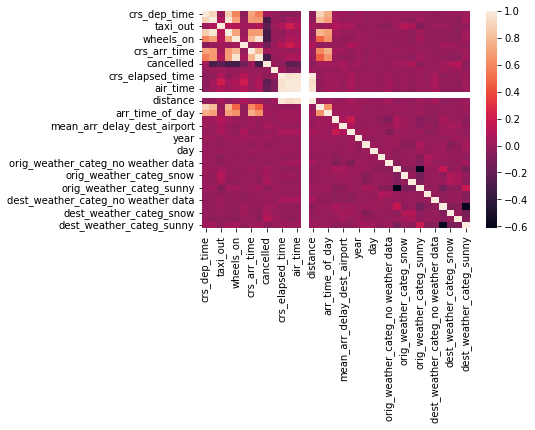

In [39]:
sns.heatmap(flights_M1.corr())

# Apply same process to test set

keep only the features we would have 1 week before the flight:

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance'],
      dtype='object')

In [98]:
test_M1 = X_test[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', 
                 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', 
                 'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance']]

In [99]:
test_M1.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
6252,2019-12-25,UA,UA_CODESHARE,UA,5517,OO,N471CA,5517,11109,COS,"Colorado Springs, CO",11292,DEN,"Denver, CO",738,840,N,62.0,1.0,73.0
4684,2019-10-22,F9,F9,F9,610,F9,N316FR,610,12217,HSV,"Huntsville, AL",13204,MCO,"Orlando, FL",1917,2207,N,110.0,1.0,535.0


## Replace null with 0

In [100]:
pd.isnull(test_M1).sum()

fl_date               0
mkt_unique_carrier    0
branded_code_share    0
mkt_carrier           0
mkt_carrier_fl_num    0
op_unique_carrier     0
tail_num              7
op_carrier_fl_num     0
origin_airport_id     0
origin                0
origin_city_name      0
dest_airport_id       0
dest                  0
dest_city_name        0
crs_dep_time          0
crs_arr_time          0
dup                   0
crs_elapsed_time      0
flights               0
distance              0
dtype: int64

In [101]:
test_M1.fillna(0, inplace = True)

## Add Features
### Add time of day feature

In [102]:
test_M1['dep_time_of_day'] = flights_M1.apply(lambda df: time_of_day(df, method='dep'), axis=1)
test_M1['arr_time_of_day'] = flights_M1.apply(lambda df: time_of_day(df, method='arr'), axis=1)

In [103]:
feature_categorizer(test_M1[['dep_time_of_day','arr_time_of_day']], test_M1)

In [104]:
test_M1.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day
6252,2019-12-25,UA,UA_CODESHARE,UA,5517,OO,N471CA,5517,11109,COS,...,DEN,"Denver, CO",738,840,N,62.0,1.0,73.0,0,0
4684,2019-10-22,F9,F9,F9,610,F9,N316FR,610,12217,HSV,...,MCO,"Orlando, FL",1917,2207,N,110.0,1.0,535.0,1,1


In [105]:
test_M1.dtypes

fl_date                object
mkt_unique_carrier     object
branded_code_share     object
mkt_carrier            object
mkt_carrier_fl_num      int64
op_unique_carrier      object
tail_num               object
op_carrier_fl_num       int64
origin_airport_id       int64
origin                 object
origin_city_name       object
dest_airport_id         int64
dest                   object
dest_city_name         object
crs_dep_time            int64
crs_arr_time            int64
dup                    object
crs_elapsed_time      float64
flights               float64
distance              float64
dep_time_of_day         int64
arr_time_of_day         int64
dtype: object

### Assign mean delay by airport feature from train data set

In [106]:
mean_delay_orig_airport

,origin,mean_arr_delay_orig_airport
0,ABE,0.461538
1,ABI,18.000000
2,ABQ,3.342857
3,ABY,-15.000000
4,ACK,-19.000000
...,...,...
307,WRG,2.666667
308,XNA,2.727273
309,XWA,-14.000000
310,YAK,81.000000


In [107]:
#merge this mean value to test set with origin as key
test_M1 = pd.merge(test_M1, mean_delay_orig_airport, how = 'left', on = ['origin'])

In [108]:
mean_delay_dest_airport.head(2)

,dest,mean_arr_delay_dest_airport
0,ABE,20.5
1,ABI,9.6


In [109]:
#merge this mean value to test set with dest as key
test_M1 = pd.merge(test_M1, mean_delay_dest_airport, how = 'left', on = ['dest'])

In [110]:
test_M1.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport
0,2019-12-25,UA,UA_CODESHARE,UA,5517,OO,N471CA,5517,11109,COS,...,738,840,N,62.0,1.0,73.0,0,0,1.562500,8.167139
1,2019-10-22,F9,F9,F9,610,F9,N316FR,610,12217,HSV,...,1917,2207,N,110.0,1.0,535.0,1,1,8.142857,6.617143


### Assign mean delay by carrier feature (created from train set)

In [111]:
mean_delay_carrier

,mkt_unique_carrier,mean_arr_delay_carrier
0,AA,5.238848
1,AS,0.251327
2,B6,12.448753
3,DL,3.892650
4,F9,16.618750
5,G4,6.624000
6,HA,1.037736
7,NK,10.057143
8,UA,8.433741
9,VX,-8.600000


In [112]:
#merge this mean value to test set with mkt unique carrier as key
test_M1 = pd.merge(test_M1, mean_delay_carrier, how = 'left', on = ['mkt_unique_carrier'])

In [113]:
test_M1.head(1)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_arr_time,dup,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier
0,2019-12-25,UA,UA_CODESHARE,UA,5517,OO,N471CA,5517,11109,COS,...,840,N,62.0,1.0,73.0,0,0,1.5625,8.167139,8.433741


In [114]:
#now we can drop the 'mkt_unique_carrier' categorical feature
test_M1.drop(['mkt_unique_carrier'], axis = 1, inplace = True)

## Add Regions

In [ ]:
#create a state_id for each dest and orig
# test_M1["orig_state_id"] = test_M1["origin_city_name"].str.split(', ')[1]
# test_M1["dest_state_id"] = test_M1["dest_city_name"].str.split(', ')[1]

In [ ]:
# make_regions(test_M1, 'origin_city_name')
# make_regions(test_M1, 'dest_city_name')

## Remove features

In [115]:
#remove categorical int features
test_M1.drop(['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id'], axis = 1, inplace = True)

In [116]:
#remove unwanted object features
test_M1.drop(['branded_code_share', 'mkt_carrier', 'op_unique_carrier', 'tail_num', 'origin', 'dest', 'dup'], axis = 1, inplace = True)

In [117]:
test_M1.dtypes

fl_date                         object
origin_city_name                object
dest_city_name                  object
crs_dep_time                     int64
crs_arr_time                     int64
crs_elapsed_time               float64
flights                        float64
distance                       float64
dep_time_of_day                  int64
arr_time_of_day                  int64
mean_arr_delay_orig_airport    float64
mean_arr_delay_dest_airport    float64
mean_arr_delay_carrier         float64
dtype: object

In [118]:
test_M1.head(2)

,fl_date,origin_city_name,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier
0,2019-12-25,"Colorado Springs, CO","Denver, CO",738,840,62.0,1.0,73.0,0,0,1.562500,8.167139,8.433741
1,2019-10-22,"Huntsville, AL","Orlando, FL",1917,2207,110.0,1.0,535.0,1,1,8.142857,6.617143,16.618750


### Get the weather "forecast" categorical features, the convert to dummy variables

In [119]:
#import weather dataset
weather_forecast = pd.read_csv('data/final_city_unique.csv',index_col=0)

In [120]:
weather_forecast.head(2)

,city,count,weather_categ
fl_date,,,
2018-10-25,"New York, NY",7,sunny
2019-07-10,"Chicago, IL",7,rain


In [121]:
#we don't want to add the count, only the weather
weather_forecast.drop('count', axis = 1, inplace = True)

In [122]:
test_M1 = pd.merge(test_M1, weather_forecast, how = 'left', left_on = ['fl_date', 'origin_city_name'], right_on = ['fl_date', 'city'])

In [123]:
test_M1.head(1)

,fl_date,origin_city_name,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier,city,weather_categ
0,2019-12-25,"Colorado Springs, CO","Denver, CO",738,840,62.0,1.0,73.0,0,0,1.5625,8.167139,8.433741,"Colorado Springs, CO",sunny


In [124]:
#rename col weather_origin
test_M1.rename({'weather_categ': 'orig_weather_categ'}, axis = 1, inplace= True)
#drop the city col which also merged
test_M1.drop('city', axis = 1, inplace = True)

In [125]:
#add the dest weather
test_M1 = pd.merge(test_M1, weather_forecast, how = 'left', left_on = ['fl_date', 'dest_city_name'], right_on = ['fl_date', 'city'])

In [126]:
#rename col weather dest
test_M1.rename({'weather_categ': 'dest_weather_categ'}, axis = 1, inplace= True)
#drop the city col which also merged
test_M1.drop('city', axis = 1, inplace = True)

In [127]:
test_M1.head(1)

,fl_date,origin_city_name,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier,orig_weather_categ,dest_weather_categ
0,2019-12-25,"Colorado Springs, CO","Denver, CO",738,840,62.0,1.0,73.0,0,0,1.5625,8.167139,8.433741,sunny,sunny


### Turn date time to year, month, day

In [128]:
test_M1['fl_date'] = pd.to_datetime(test_M1['fl_date'])

In [129]:
#split date into three cols
import datetime as dt
test_M1['year'] = test_M1['fl_date'].dt.year
test_M1['month'] = test_M1['fl_date'].dt.month
test_M1['day'] = test_M1['fl_date'].dt.day

In [130]:
test_M1.head(1)

,fl_date,origin_city_name,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier,orig_weather_categ,dest_weather_categ,year,month,day
0,2019-12-25,"Colorado Springs, CO","Denver, CO",738,840,62.0,1.0,73.0,0,0,1.5625,8.167139,8.433741,sunny,sunny,2019,12,25


In [131]:
#now we can drop date
test_M1.drop('fl_date', axis = 1, inplace = True)

In [132]:
#now we can drop the city names
test_M1.drop(['origin_city_name', 'dest_city_name'], axis = 1, inplace = True)

### Now we can create the dummy variables

In [133]:
test_M1 = pd.get_dummies(test_M1, drop_first=True)

In [134]:
test_M1.head(1)

,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,dep_time_of_day,arr_time_of_day,mean_arr_delay_orig_airport,mean_arr_delay_dest_airport,mean_arr_delay_carrier,...,orig_weather_categ_no weather data,orig_weather_categ_rain,orig_weather_categ_snow,orig_weather_categ_snow & rain,orig_weather_categ_sunny,dest_weather_categ_no weather data,dest_weather_categ_rain,dest_weather_categ_snow,dest_weather_categ_snow & rain,dest_weather_categ_sunny
0,738,840,62.0,1.0,73.0,0,0,1.5625,8.167139,8.433741,...,0,0,0,0,1,0,0,0,0,1


In [137]:
#final null and dtype check:
pd.isnull(test_M1).sum()

crs_dep_time                          0
crs_arr_time                          0
crs_elapsed_time                      0
flights                               0
distance                              0
dep_time_of_day                       0
arr_time_of_day                       0
mean_arr_delay_orig_airport           0
mean_arr_delay_dest_airport           0
mean_arr_delay_carrier                0
year                                  0
month                                 0
day                                   0
orig_weather_categ_no weather data    0
orig_weather_categ_rain               0
orig_weather_categ_snow               0
orig_weather_categ_snow & rain        0
orig_weather_categ_sunny              0
dest_weather_categ_no weather data    0
dest_weather_categ_rain               0
dest_weather_categ_snow               0
dest_weather_categ_snow & rain        0
dest_weather_categ_sunny              0
dtype: int64

In [138]:
test_M1.dtypes

crs_dep_time                            int64
crs_arr_time                            int64
crs_elapsed_time                      float64
flights                               float64
distance                              float64
dep_time_of_day                         int64
arr_time_of_day                         int64
mean_arr_delay_orig_airport           float64
mean_arr_delay_dest_airport           float64
mean_arr_delay_carrier                float64
year                                    int64
month                                   int64
day                                     int64
orig_weather_categ_no weather data      uint8
orig_weather_categ_rain                 uint8
orig_weather_categ_snow                 uint8
orig_weather_categ_snow & rain          uint8
orig_weather_categ_sunny                uint8
dest_weather_categ_no weather data      uint8
dest_weather_categ_rain                 uint8
dest_weather_categ_snow                 uint8
dest_weather_categ_snow & rain    

<AxesSubplot:>

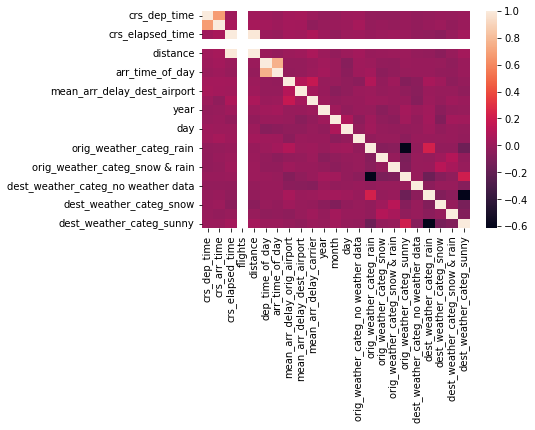

In [139]:
sns.heatmap(test_M1.corr())

## Export Model1 as csv

In [140]:
flights_M1.to_csv('data/X_train_M1.csv', header=True, index=False)

In [141]:
test_M1.to_csv('data/X_test_M1.csv', header=True, index=False)

### Run Model 1

In [142]:
from src.modules.data_preprocessing import regression

In [144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [145]:
regressor_list = [LinearRegression, SVR, RandomForestRegressor]

In [147]:
regression(flights_M1, test_M1, y_train, y_test, regressor_list)

ValueError: X has 23 features, but StandardScaler is expecting 35 features as input.